In [22]:
import keras
import tensorflow as tf
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)


Keras version: 3.5.0
TensorFlow version: 2.17.0


In [23]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

In [24]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [25]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [27]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [28]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.tf.image.extract_patches(images, size=self.patch_size)
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 72 X 72
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 768


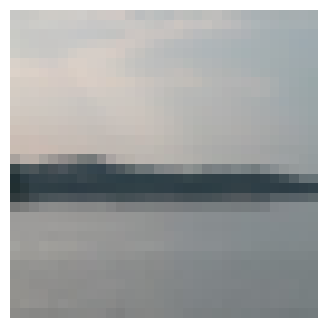

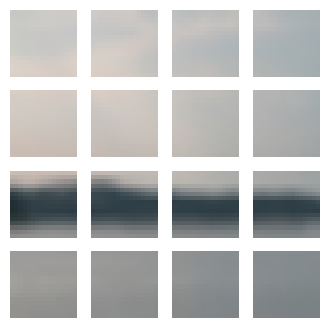

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def extract_patches(image, patch_size):
    """ Extrai patches quadrados de uma imagem. """
    patches = []
    h, w, _ = image.shape
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    return np.array(patches)

image_size = 72  # Tamanho da imagem
patch_size = 16  # Tamanho do patch

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")


resized_image = cv2.resize(image, (image_size, image_size))

patches = extract_patches(resized_image, patch_size)

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[0]}")
print(f"Elements per patch: {patches.shape[1] * patches.shape[2] * patches.shape[3]}")

# Exibe os patches
n = int(np.sqrt(patches.shape[0]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches):
    ax = plt.subplot(n, n, i + 1)
    plt.imshow(patch.astype("uint8"))
    plt.axis("off")
plt.show()


In [35]:
import tensorflow as tf
from tensorflow.keras import layers

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]

        # Compute number of patches
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        num_patches = num_patches_h * num_patches_w
        patch_height = self.patch_size
        patch_width = self.patch_size

        # Extract patches
        patches = tf.image.extract_patches(
            images,
            sizes=[1, patch_height, patch_width, 1],
            strides=[1, patch_height, patch_width, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        
        # Reshape patches to [batch_size, num_patches, patch_height * patch_width * channels]
        patch_dim = patch_height * patch_width * channels
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dim])
        return patches

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        num_patches = num_patches_h * num_patches_w
        patch_height = self.patch_size
        patch_width = self.patch_size

        patch_dim = patch_height * patch_width * channels
        return (batch_size, num_patches, patch_dim)
    
    import tensorflow as tf
from tensorflow.keras import layers

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            tf.range(start=0, limit=self.num_patches, delta=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config



In [36]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [37]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")



/home/lucas/PIBIC/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:1383: UserWarning: Layer 'patch_encoder' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Dimensions must be equal, but are 16 and 144 for '{{node add}} = AddV2[T=DT_FLOAT](dense_2_1/Add, embedding_1/GatherV2)' with input shapes: [?,16,64], [1,144,64].''
  warnings.warn(


ValueError: Exception encountered when calling PatchEncoder.call().

[1mCould not automatically infer the output shape / dtype of 'patch_encoder' (of type PatchEncoder). Either the `PatchEncoder.call()` method is incorrect, or you need to implement the `PatchEncoder.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimensions must be equal, but are 16 and 144 for '{{node add}} = AddV2[T=DT_FLOAT](dense_2_1/Add, embedding_1/GatherV2)' with input shapes: [?,16,64], [1,144,64].[0m

Arguments received by PatchEncoder.call():
  • args=('<KerasTensor shape=(None, 16, 768), dtype=float32, sparse=False, name=keras_tensor_34>',)
  • kwargs=<class 'inspect._empty'>